In [203]:
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from sklearn import decomposition
from bs4 import BeautifulSoup
import pickle
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import math
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import plot_confusion_matrix 
%matplotlib inline
import pickle
from tqdm import tqdm
from datetime import datetime as dt
import re
warnings.filterwarnings("ignore")
print("Importing done perfectly")

Importing done perfectly


# Amazon Fine Food Reviews Analysis and Visualization using PCA.

# Text Preprocessing 

In [82]:
#Importing data set 
df=pd.read_csv(r'C:\Users\vamsi\Desktop\Tensor flow\Reviews.csv')


In [83]:
filtered_data=df[df['Score']!= 3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [84]:
filtered_data['SentimentPolarity']=filtered_data['Score'].map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Classlabel']=filtered_data['SentimentPolarity'].map(lambda x: 1 if x=='Positive' else 0 )

In [85]:
print("Number of reviews in our dataset", filtered_data.shape[0])
print("Number of features in our dataset", filtered_data.shape[1])

Number of reviews in our dataset 525814
Number of features in our dataset 12


In [86]:
print("The shape of the filtered data : {}".format(filtered_data.shape))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered data : (525814, 12)
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


In [87]:
display=filtered_data[filtered_data['UserId']=='AR5J8UI46CURR']
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Classlabel
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1


In [88]:
sorted_data=filtered_data.sort_values('Time', ascending=False, na_position='last')

In [89]:
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the dataset after deduplication, Stage 1: {}".format(filtered_duplicates.shape))

The shape of the dataset after deduplication, Stage 1: (364173, 12)


1) In the above table, the review given by "Geetha Krishnan" is shared to all the similar product id and it is impossibile to give a review at the same timestamp. Thereby it is very necessary to dicard all such data

2) HelpfulnessNumerator= It tells number of person feels whether the review is useful for them or not

3) HelpfulnessDenominator= It is total number of person feels useful and not useful. (basically it is both useful+not useful)

It is therefore HelpfulnessDenominator>=HelpfulnessNumerator, we need to remove the data points which doesn't follows this rule

In [90]:
final_data=filtered_duplicates[filtered_duplicates['HelpfulnessDenominator']>=filtered_duplicates['HelpfulnessNumerator']]

In [91]:
print("The shape of the dataset after deduplication, Stage 2: {}".format(final_data.shape))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

The shape of the dataset after deduplication, Stage 2: (364171, 12)
The number of positive and negative reviews before the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64


In [92]:
print('Precentage of data lost after removing duplicates and unwanted data')
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

Precentage of data lost after removing duplicates and unwanted data
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194


In [93]:
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.\n")
final_data.head(5)


First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Classlabel
132755,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
470582,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
303245,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
303244,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
504113,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


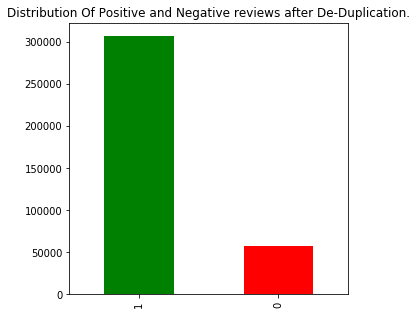

In [94]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Classlabel"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

In [95]:
Sentence1=final_data['Text'].values[0]
print(Sentence1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*200)

Sentence2=final_data['Text'].values[500]
print(Sentence2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[500]))
print("="*200)

Sentence3=final_data['Text'].values[1000]
print(Sentence3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*200)

Sentence4=final_data['Text'].values[1500]
print(Sentence3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*200)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
i took the lollipops to work and shared them w/the office about 3 weeks ago. only 5 are left.  they are yummy and the perfect size sweet treat.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive


In text preprocessing the following steps are done 

1) Removal of url's

2) Removal of numeric characters

3) Removal of punctuation,full stops, commas, question marks etc...

4) Converting every word into lowercase

5) Removal of http's:

# Text Preprocessing

In [96]:
def removehtml(sentence):
    pattern=re.compile('<.*?>')
    sentence = re.sub(pattern,' ',sentence)
    return sentence
def removeNumbers(sentence):
    sentence = re.sub('\S*\d\S*', ' ', sentence).strip()
    return (sentence)
def removePunctuations(sentence):
    sentence  = re.sub('[^a-zA-Z]',' ',sentence)
    return (sentence)
def removeURL(sentence):
    sentence = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", sentence)
    return (sentence)
def removePatterns(sentence): 
    sentence  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (sentence)

In [97]:
def decontracted(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

In [98]:
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not




  0%|          | 0/364171 [00:00<?, ?it/s]


  0%|          | 53/364171 [00:00<11:38, 520.99it/s]


  0%|          | 113/364171 [00:00<11:12, 541.35it/s]


  0%|          | 191/364171 [00:00<10:13, 593.71it/s]


  0%|          | 235/364171 [00:00<11:54, 509.03it/s]


  0%|          | 300/364171 [00:00<11:09, 543.40it/s]


  0%|          | 349/364171 [00:00<11:59, 505.35it/s]


  0%|          | 406/364171 [00:00<11:36, 522.14it/s]


  0%|          | 456/364171 [00:00<11:51, 510.99it/s]


  0%|          | 506/364171 [00:00<12:04, 502.19it/s]


  0%|          | 563/364171 [00:01<11:43, 516.92it/s]


  0%|          | 615/364171 [00:01<12:31, 483.61it/s]


  0%|          | 666/364171 [00:01<12:23, 488.77it/s]


  0%|          | 727/364171 [00:01<11:49, 512.32it/s]


  0%|          | 795/364171 [00:01<10:59, 550.88it/s]


  0%|          | 868/364171 [00:01<10:12, 593.59it/s]


  0%|          | 936/364171 [00:01<09:49, 615.95it/s]


  0%|          | 1003/364171 [00:01<09:39, 626.35it/s]




Text(0, 0.5, 'Number of Words')

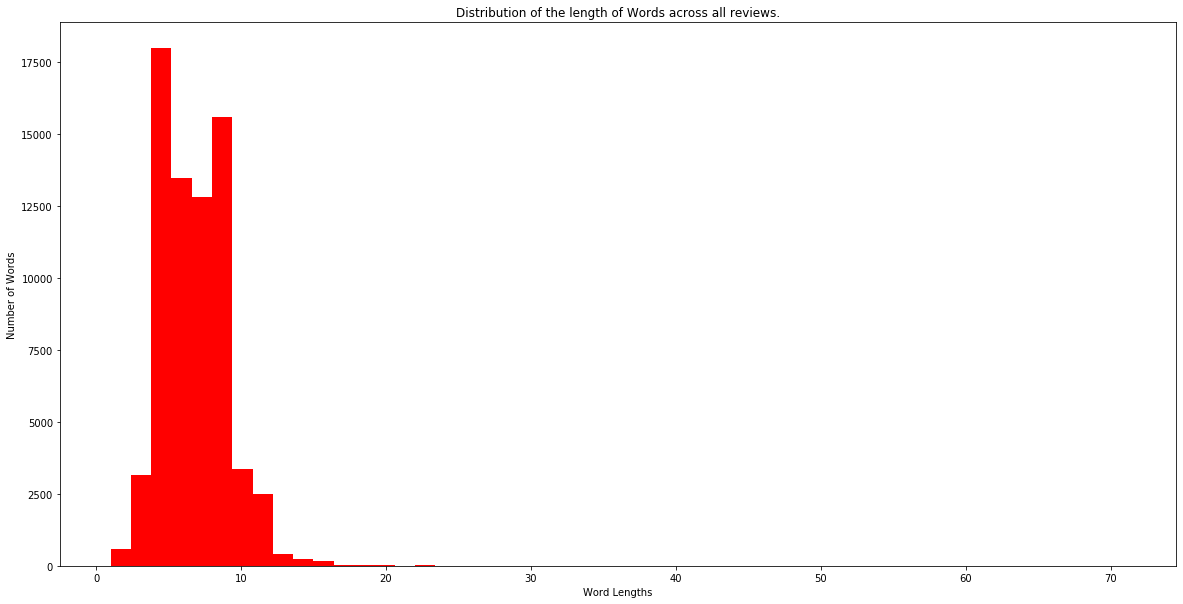

In [99]:
total_words=[]
for review in tqdm(final_data['Text'].values):
    review = decontracted(review)
    review = removeNumbers(review)
    review = removehtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)
total_words = list(set(total_words))

length_words = []
for i in tqdm(total_words):
    length = len(i)
    length_words.append(length)



Text(0, 0.5, 'Number of Words')

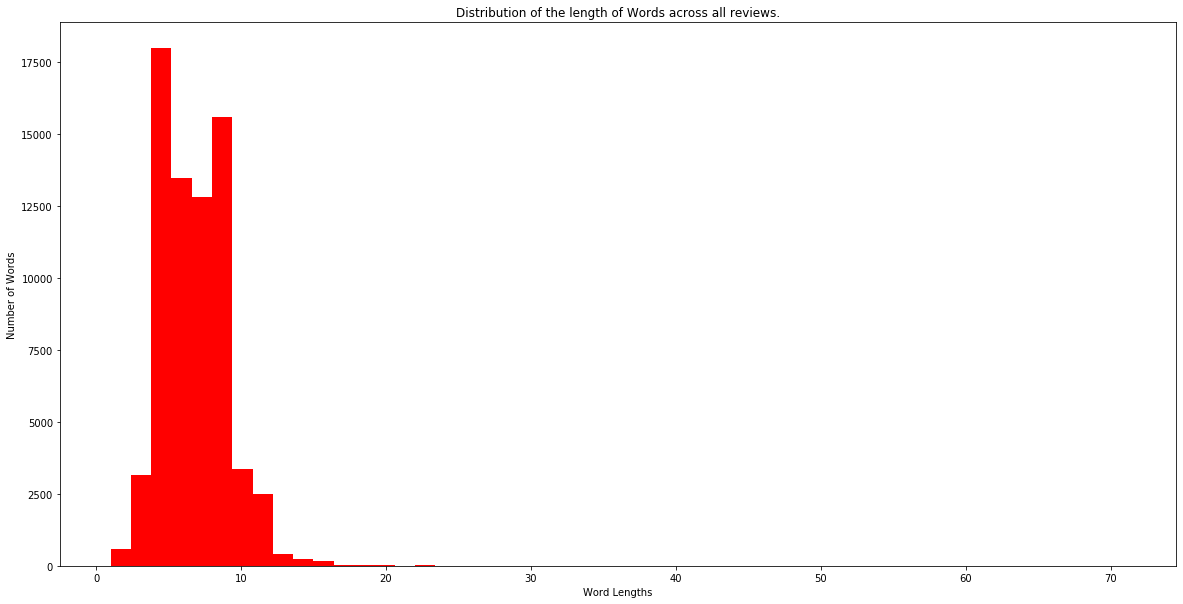

In [100]:
plt.figure(figsize=(20,10))
plt.hist(length_words, color = 'red', bins=50)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

It was observed from the above histogram that they are very less words in of length above 16 and length below 2 

In [105]:
import warnings
warnings.filterwarnings("ignore")
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removehtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words 







  0%|          | 0/364171 [00:00<?, ?it/s]




  0%|          | 48/364171 [00:00<13:07, 462.64it/s]




  0%|          | 101/364171 [00:00<12:42, 477.48it/s]




  0%|          | 153/364171 [00:00<12:29, 485.75it/s]




  0%|          | 204/364171 [00:00<12:20, 491.74it/s]




  0%|          | 252/364171 [00:00<12:29, 485.54it/s]




  0%|          | 300/364171 [00:00<12:44, 475.69it/s]




  0%|          | 343/364171 [00:00<13:13, 458.40it/s]




  0%|          | 386/364171 [00:00<13:41, 442.97it/s]




  0%|          | 428/364171 [00:00<14:19, 423.04it/s]




  0%|          | 481/364171 [00:01<13:30, 448.57it/s]




  0%|          | 526/364171 [00:01<14:06, 429.36it/s]




  0%|          | 572/364171 [00:01<13:51, 437.21it/s]




  0%|          | 617/364171 [00:01<13:48, 438.73it/s]




  0%|          | 661/364171 [00:01<14:11, 426.71it/s]




  0%|          | 704/364171 [00:01<15:22, 394.04it/s]




  0%|          | 749/364171 [00:01<14:49, 408.49it/s]




  0%|          | 793/

In [114]:
import pickle               #( More about pickle----> https://www.geeksforgeeks.org/understanding-python-pickling-example/)
with open('all_positive_words_.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words_.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

The length of the data corpus is : 364171


In [115]:
final_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Classlabel,CleanedText
132755,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,the premium bourbon madagascar vanilla vannila...
470582,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...
303245,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...
303244,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,this gone treat dinner treat dog work run chan...
504113,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,this firm favorit breakfast time hous mani yea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,Positive,1,beetlejuic excel funni movi keaton hilari wack...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",Positive,1,twist rumplestiskin captur film star michael k...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Positive,1,beetlejuic well written movi everyth excel fro...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,Positive,1,rememb see show air televis year ago child sis...


In [116]:
final_data.to_csv(r'C:\Users\vamsi\Desktop\Tensor flow\Amazon_final_data.csv')


In [117]:
processed_db=pd.read_csv(r'C:\Users\vamsi\Desktop\Tensor flow\Amazon_final_data.csv')


In [118]:
processed_db

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Classlabel,CleanedText
0,132755,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,the premium bourbon madagascar vanilla vannila...
1,470582,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...
2,303245,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...
3,303244,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,this gone treat dinner treat dog work run chan...
4,504113,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,this firm favorit breakfast time hous mani yea...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364166,451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,5,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,Positive,1,beetlejuic excel funni movi keaton hilari wack...
364167,374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",Positive,1,twist rumplestiskin captur film star michael k...
364168,451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Positive,1,beetlejuic well written movi everyth excel fro...
364169,150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,Positive,1,rememb see show air televis year ago child sis...


## PCA for Visualization

In order to perform PCA it is very important to perform standardization. Each feature will be of different scale. Thereby PCA algorithm will be effected if we don't perform standardization. 

In [201]:
def standardize(data):
    from sklearn.preprocessing import StandardScaler
    data_std = StandardScaler(with_mean=False).fit_transform(data)
    return data_std

def pca_vis(data, labels):
    #Initializing the pca & Configuring the parameteres, the number of components = 2
    st = dt.now()
    pca = decomposition.PCA(n_components = 2)
    pca_reduced = pca.fit_transform(data)

    #pca_reduced will contain the 2-d projects of simple data
    print("Shape of pca_reduced.shape = ", pca_reduced.shape)
    
    # attaching the label for each 2-d data point 
    pca_data = np.vstack((pca_reduced.T, labels)).T
    print("shape of pca_data.shape = ", pca_data.shape)

    #Creating a new data frame which help us in ploting the result data
    pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal_component", "2nd_principal_component", "labels"))
    sns.FacetGrid(pca_df, hue="labels", height=6).map(plt.scatter, '1st_principal_component', '2nd_principal_component').add_legend()
    plt.show()
    print("Time taken to perform Principal Component Analysis: ",dt.now()-st)

In [198]:
def pca_redu(data,labels):
    # PCA for dimensionality redcution (non-visualization)
    from sklearn.decomposition import PCA
    pca = PCA()
    pca.n_components = data.shape[1]
    pca_data = pca.fit_transform(data)

    percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)

    cum_var_explained = np.cumsum(percentage_var_explained)

    # Plot the PCA spectrum
    plt.figure(1, figsize=(6, 4))
    plt.clf()
    plt.plot(cum_var_explained, linewidth=2)
    plt.axis('tight')
    plt.grid()
    plt.xlabel('n_components')
    plt.ylabel('Cumulative_explained_variance')
    plt.show()

In [207]:
processed_db=pd.read_csv(r'C:\Users\vamsi\Desktop\Tensor flow\Amazon_final_data.csv')
processed_db=processed_db.dropna()
#Balancing the dataset. Taking 10000 reviews belonging to each classes
df0 = processed_db[processed_db['Classlabel'] == 0]
df1 = processed_db[processed_db['Classlabel'] == 1]
df_balanced = pd.concat([df1.sample(18000,random_state=0),df0.sample(18000, random_state=0)])

#Split the data into train and test set. The train set will contain 40K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = df_balanced['CleanedText']
labels=df_balanced['Classlabel']

df_balanced.head()


,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Classlabel,CleanedText
231345,127748,127749,B001BOVE54,AZG0XARYMT82I,"T. L. Youngblood ""Scrap Maniac""",3,4,5,1294272000,I'm no expert but....,"I'm no expert, but I consulted with the expert...",Positive,1,expert consult expert find right food larg mal...
264277,421909,421910,B001E5E2CC,AM3YZMYZEHB67,"Lisa in W.C. ""Lisa""",0,0,5,1277164800,DELICIOUS!,Delicious - great price. The candies are fres...,Positive,1,delici great price the candi fresh rememb deli...
11277,58570,58571,B00434KNJW,A2QCE3YB0C8G2C,Kelly Lyngstad,0,0,5,1349395200,Apple Cheerios,I love these cheerios and it is a really wonde...,Positive,1,love cheerio realli wonder valu continu get ce...
195281,566739,566740,B001PQTYN2,A2B86K6WPBFGK3,Dr Jeff,0,0,5,1306713600,5 stars,Saves my money because a dime sized amount of ...,Positive,1,save money dime size amount stuff work whole m...
234681,139493,139494,B00112EUPM,A2ZQKCJFWQL8D,"A. Russa ""OC""",1,1,5,1292889600,Great way to get nutrients,I put a scoop in my post-workout drink and it ...,Positive,1,put scoop post workout drink mix well not like...


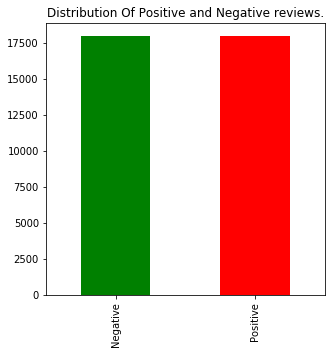

In [191]:
df_balanced["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews.',figsize=(5,5))

In [194]:
df_balanced['CleanedText'].isnull().sum()

0

In [195]:
list_of_sentence=[]
for sentence in X_train:
    sentence=sentence.split()
    list_of_sentence.append(sentence)
print("The size of the Word2Vec text corpus : ",len(list_of_sentence))

The size of the Word2Vec text corpus :  36000


In [126]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

In [173]:
if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.8278713226318359), ('awesom', 0.7778830528259277), ('excel', 0.7547289133071899), ('wonder', 0.7359174489974976), ('nice', 0.7181508541107178), ('terrif', 0.717614471912384), ('perfect', 0.716962993144989), ('fantast', 0.7033336758613586), ('amaz', 0.6928847432136536), ('decent', 0.6884824633598328)]
[('best', 0.8150664567947388), ('greatest', 0.7056411504745483), ('disgust', 0.6755039691925049), ('grossest', 0.6677985191345215), ('weakest', 0.64492267370224), ('aw', 0.6433859467506409), ('have', 0.6404340267181396), ('horribl', 0.6367049813270569), ('nastiest', 0.6271100044250488), ('tastiest', 0.619223415851593)]


### W2V

In [196]:
def vectorize(dataset):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
    print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))
    
    #min_count = 5 considers only those words for our model which occurs atleast 5 times
    word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6)
    word2vec_words = list(word2vec_model.wv.vocab)
    print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in word2vec_corpus: #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    print("\nThe length of the sentence vectors :",len(sent_vectors))
    print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors

X_train_vectors = vectorize(X_train)

The size of the Word2Vec text corpus :  36000

The number of words that occured minimum 5 times :  8464

The length of the sentence vectors : 36000

Size of each vector :  200


The shape of our Avg Word2Vec train vectorizer  (36000, 200)
Shape of pca_reduced.shape =  (36000, 2)
shape of pca_data.shape =  (36000, 3)


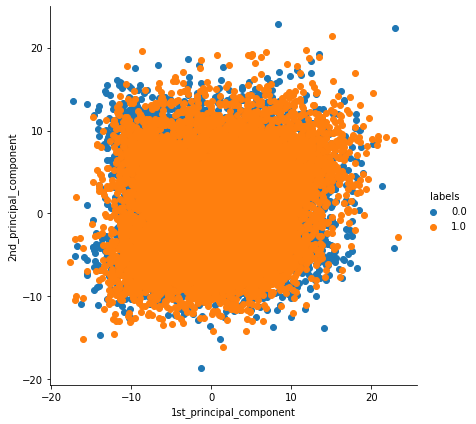

Time taken to perform Principal Component Analysis:  0:00:01.841587


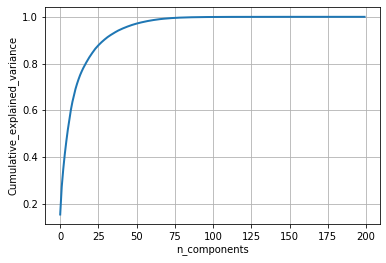

In [205]:
X_train_vec = standardize(X_train_vectors)

print("The shape of our Avg Word2Vec train vectorizer ",X_train_vec.shape)

#Perform PCA visualization using 2 components
pca_vis(X_train_vec, labels)

#Check to see how many number of features can be retained which explains the most variance.
pca_redu(X_train_vec,labels)

### AvgW2V

The size of the Word2Vec text corpus :  36000
The shape of our Avg Word2Vec train vectorizer  (36000, 200)
Shape of pca_reduced.shape =  (36000, 2)
shape of pca_data.shape =  (36000, 3)


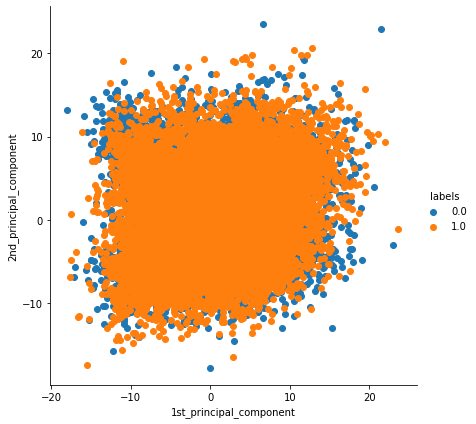

Time taken to perform Principal Component Analysis:  0:00:01.771247


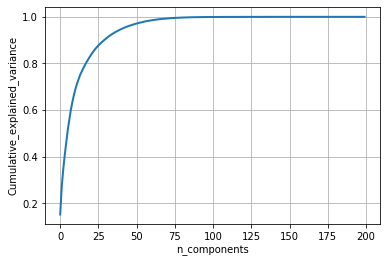

In [209]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in (word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vec= vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_train_vec = standardize(X_train_vec)

print("The shape of our Avg Word2Vec train vectorizer ",X_train_vec.shape)

#Perform PCA visualization using 2 components
pca_vis(X_train_vec, labels)

#Check to see how many number of features can be retained which explains the most variance.
pca_redu(X_train_vec, labels)